In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import math

In [62]:
def denoise(cleanfile,noisyfile,noisyDb):
  #Read clean wavfile
  clean_stream = wave.open(cleanfile)
  clean_params = clean_stream.getparams()
  nchannels_clean, sampwidth_clean, fs_clean, nframes_clean = clean_params[:4]
  clean_data = clean_stream.readframes(nframes_clean)
  clean_stream.close()

  # convert waveform data to an array
  clean = np.frombuffer(clean_data, dtype=np.short)

  #Read noisy wavfile
  stream = wave.open(noisyfile)
  params = stream.getparams()
  nchannels, sampwidth, fs, nframes = params[:4]
  data_arr = stream.readframes(nframes)
  stream.close()

  # convert waveform data to an array
  data = np.frombuffer(data_arr, dtype=np.short)

  # calculation parameters
  N = 20 * fs // 1000      # frame size in samples
  L = 50                   # window overlap in percent of frame
  len1 = N * L // 100   # overlap length
  len2 = N - len1          # window length - overlap length
  Thres = 3 #Threshold for unvoiced and voiced speech   
  alpha = 0.9

  # sine window
  i = np.linspace(0,N - 1,N)
  win = np.sqrt(2/(N + 1)) * np.sin(np.pi * (i + 1) / (N + 1))

  nFFT = 2 * 2 ** 8
  noise_mean = np.zeros(nFFT)
  j = 1

  #Estimating noise mean magnitude from unvoiced speech. Unvoiced speech could be in the first 5 frames
  for k in range(1, 6):
    noise_mean = noise_mean + abs(np.fft.fft(win * data[j:j + N], nFFT))
    j = j + N
  noise_mu = noise_mean / 5

  k = 1
  data_old = np.zeros(len1)
  Nframes = len(data) // len2 - 1
  recon = np.zeros(Nframes * len2)
  for n in range(0, Nframes):
    #Window the frame
    windowed = win * data[k-1:k + N - 1]
    #Fourier transform
    transform = np.fft.fft(windowed,nFFT)
    mag = abs(transform)     
    #save the noisy phase information as we need it later for reconstruction
    theta = np.angle(transform)  

    #Posterior SNR
    SNRpos = 10 * np.log10(np.linalg.norm(mag, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)

    #Wiener filter
    #Subtract estimated noise from the transform
    sub_speech = mag - noise_mu
    # When the pure signal is less than the noise signal power
    diffw = mag - noise_mu  
    #Make subtracted speech negative components equal to zero
    def find_negative(inList):
        index_list = []
        for i in range(len(inList)):
            if inList[i] < 0:
                index_list.append(i)
        return index_list
    neg_Indices = find_negative(diffw)
    if len(neg_Indices) > 0:
        sub_speech[neg_Indices] = 0
    
    # Priori SNR
    SNRpri = 10 * np.log10(np.linalg.norm(sub_speech, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)

    # parameter to deal mel
    mel_max = 10
    mel_0 = (1 + 4 * mel_max) / 5
    s = 25 / (mel_max - 1)
    # deal mel
    def get_mel(SNR):
        if -5.0 <= SNR <= 20.0:
            a = mel_0 - SNR / s
        else:
            if SNR < -5.0:
                a = mel_max
            if SNR > 20:
                a = 1
        return a

    # setting mel
    mel = get_mel(SNRpri) 
    G_k = sub_speech ** 2 / (sub_speech ** 2 + mel * noise_mu ** 2)
    wf_speech = G_k * mag

    if SNRpos < Thres:  # Update noise spectrum
        noise_temp = alpha * noise_mu + (1 - alpha) * mag  # Smoothing processing noise power spectrum
        noise_mu = noise_temp  # New noise amplitude spectrum
    
    # add phase to the wiener filtered output
    x_phase = wf_speech * np.exp(1j * theta)
    
    # take the IFFT
    xi = np.fft.ifft(x_phase).real
    
    # Reconstruct final output
    recon[k-1:k + len2 - 1] = data_old + xi[0:len1]
    data_old = xi[0 + len1:N]

    k = k + len2

  # save reconstructed wave file
  reconstream = wave.open('out-'+ noisyfile, 'wb')

  # setting parameters
  reconstream.setparams(params)
  # set waveform file .tostring()Convert array to data
  recon_data = ((len2 / sum(win)) * recon).astype(np.short)
  reconstream.writeframes(recon_data.tobytes())
  # close wave file
  reconstream.close()

  # enchanced speech FFT
  es_FFT = abs(np.fft.fft(len2 / sum(win) * recon))

  # plot wave
  
  fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(20,15))
  fig.tight_layout()
  fig.suptitle('Wiener filtering for noise level '+ str(noisyDb) + ' dB')
  axes[0,0].plot(clean)
  axes[0,0].set_title('Clean Speech')
  
  axes[1,0].plot(data)
  axes[1,0].set_title('Noisy Speech')
  
  axes[2,0].plot(len2 / sum(win) * recon)
  axes[2,0].set_title('Enhanced Speech')
  
  axes[0,1].specgram(clean,NFFT=nFFT,Fs=fs)
  axes[0,1].set_title('Clean Speech spectrogram')
 
  axes[1,1].specgram(data,NFFT=nFFT,Fs=fs)
  axes[1,1].set_title('Noisy Speech spectrogram')
  
  axes[2,1].specgram(recon,NFFT=nFFT,Fs=fs)
  axes[2,1].set_title('Reconstructed Speech spectrogram')

  plt.show()
  fig.savefig('Wiener_filtering_results_noise_level_' + str(noisyDb) + '_dB.png')

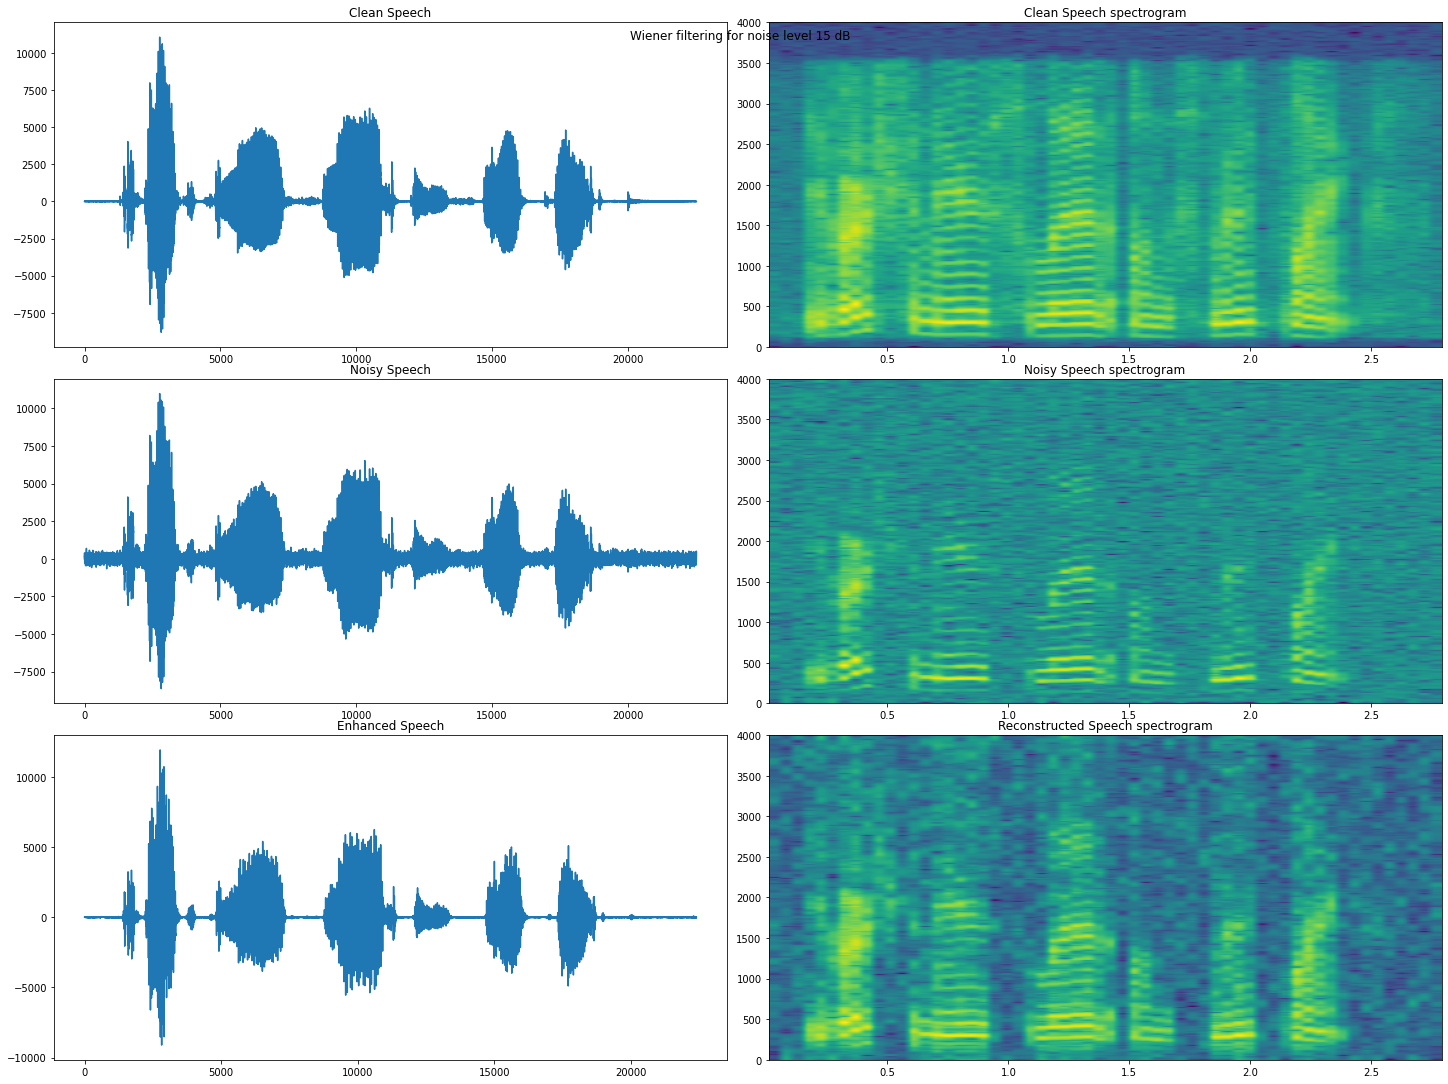

In [63]:
denoise('wiener_filtering_sp01.wav','wiener_filtering_in_SNR15_sp01.wav',15)

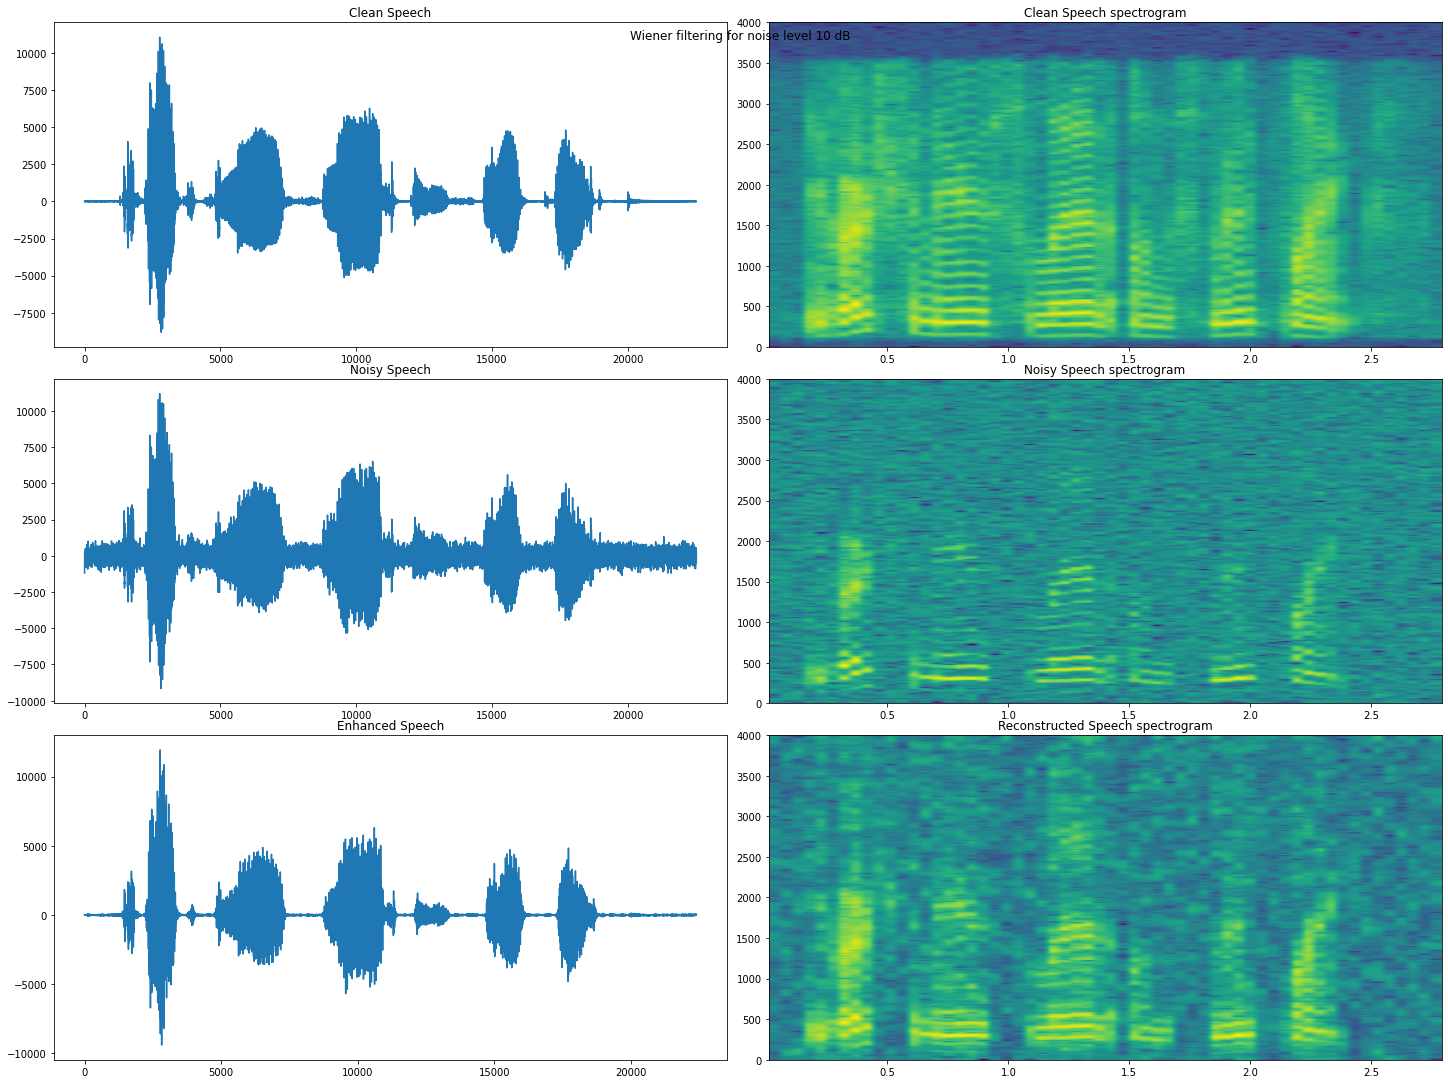

In [64]:
denoise('wiener_filtering_sp01.wav','wiener_filtering_in_SNR10_sp01.wav',10)

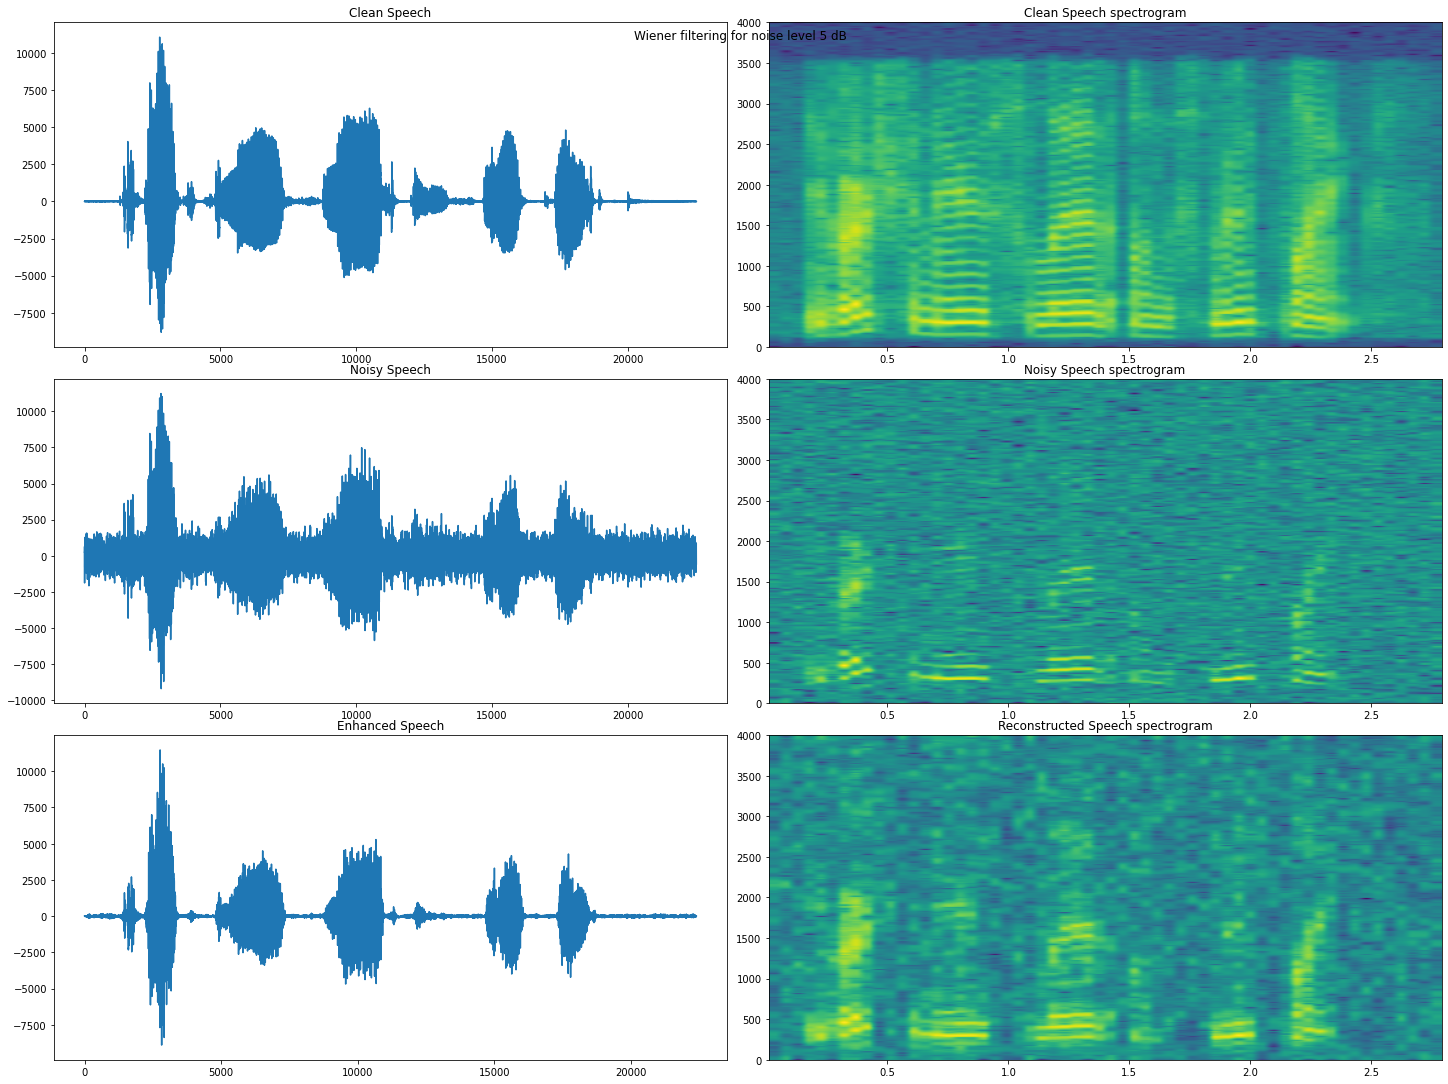

In [65]:
denoise('wiener_filtering_sp01.wav','wiener_filtering_in_SNR5_sp01.wav',5)